#  Import Libraries & Load Dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Customer ID                  30000 non-null  object 
 1   Name                         30000 non-null  object 
 2   Gender                       29947 non-null  object 
 3   Age                          30000 non-null  int64  
 4   Income (USD)                 25424 non-null  float64
 5   Income Stability             28317 non-null  object 
 6   Profession                   30000 non-null  object 
 7   Type of Employment           22730 non-null  object 
 8   Location                     30000 non-null  object 
 9   Loan Amount Request (USD)    30000 non-null  float64
 10  Current Loan Expenses (USD)  29828 non-null  float64
 11  Expense Type 1               30000 non-null  object 
 12  Expense Type 2               30000 non-null  object 
 13  Dependents      

None

,Age,Income (USD),Loan Amount Request (USD),Current Loan Expenses (USD),Dependents,Credit Score,No. of Defaults,Property ID,Property Age,Property Type,Co-Applicant,Property Price,Loan Sanction Amount (USD)
count,30000.000000,2.542400e+04,30000.000000,29828.000000,27507.000000,28297.000000,30000.000000,30000.000000,2.515000e+04,30000.000000,30000.000000,3.000000e+04,29660.000000
mean,40.092300,2.630574e+03,88826.333855,400.936876,2.253027,739.885381,0.193933,501.934700,2.631119e+03,2.460067,-4.743867,1.317597e+05,47649.342208
std,16.045129,1.126272e+04,59536.949605,242.545375,0.951162,72.163846,0.395384,288.158086,1.132268e+04,1.118562,74.614593,9.354955e+04,48221.146686
min,18.000000,3.777000e+02,6048.240000,-999.000000,1.000000,580.000000,0.000000,1.000000,3.777000e+02,1.000000,-999.000000,-9.990000e+02,-999.000000
25%,25.000000,1.650457e+03,41177.755000,247.667500,2.000000,681.880000,0.000000,251.000000,1.650450e+03,1.000000,1.000000,6.057216e+04,0.000000
50%,40.000000,2.222435e+03,75128.075000,375.205000,2.000000,739.820000,0.000000,504.000000,2.223250e+03,2.000000,1.000000,1.099936e+05,35209.395000
75%,55.000000,3.090593e+03,119964.605000,521.292500,3.000000,799.120000,0.000000,751.000000,3.091408e+03,3.000000,1.000000,1.788807e+05,74261.250000
max,65.000000,1.777460e+06,621497.820000,3840.880000,14.000000,896.260000,1.000000,999.000000,1.777460e+06,4.000000,1.000000,1.077967e+06,481907.320000


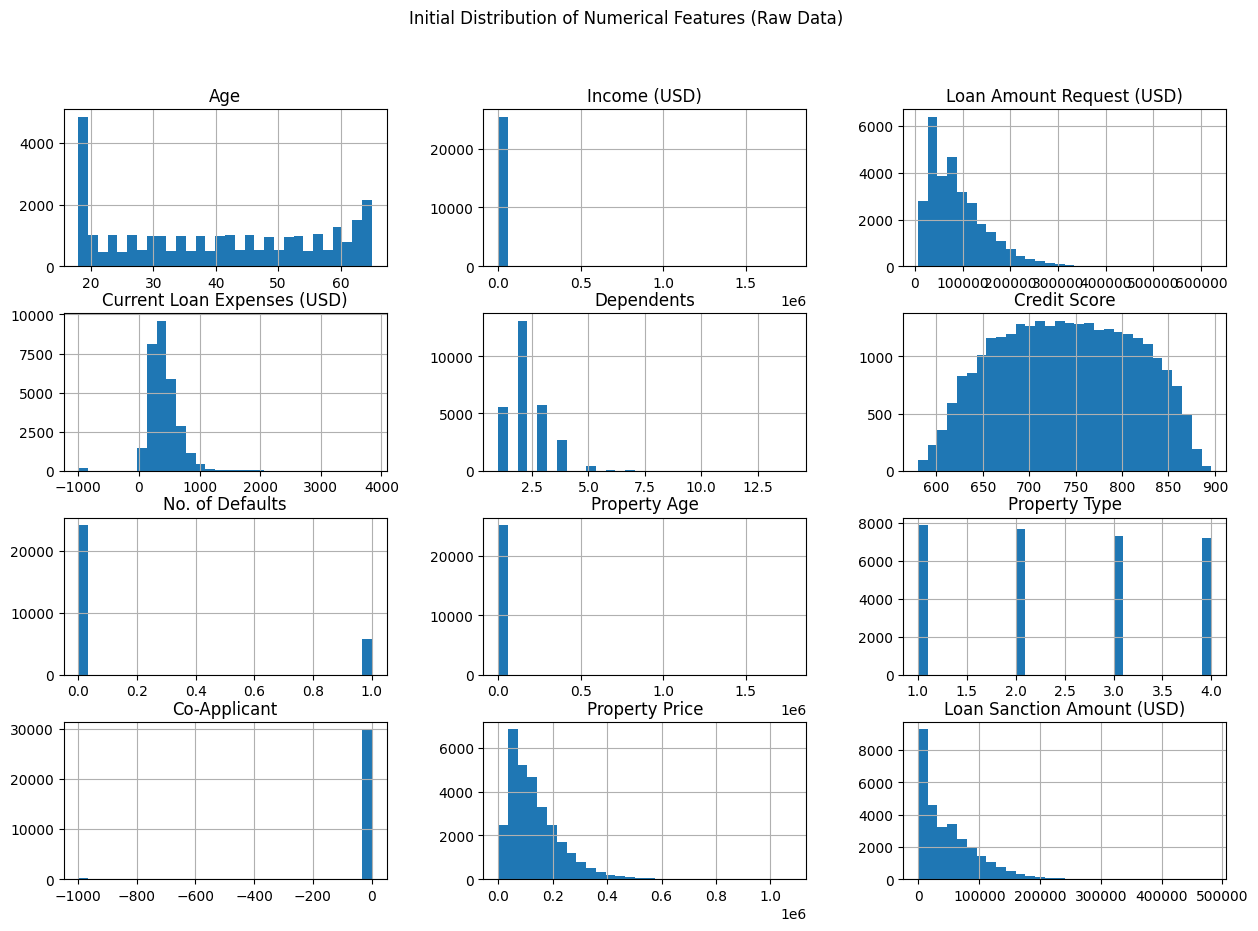

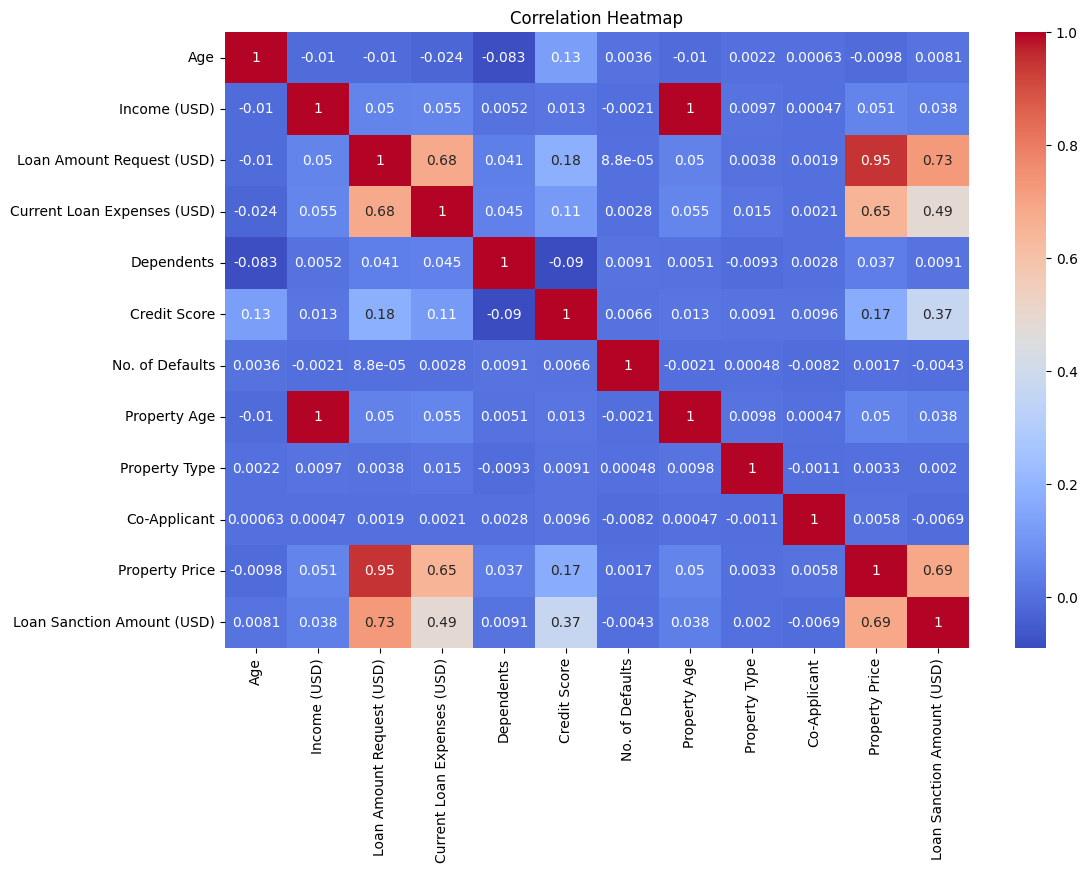

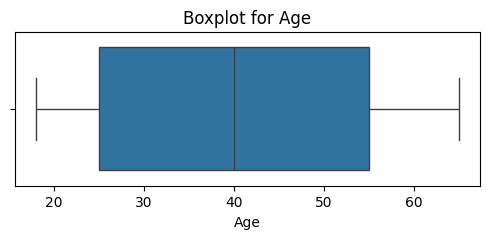

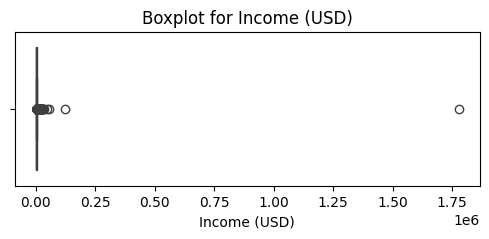

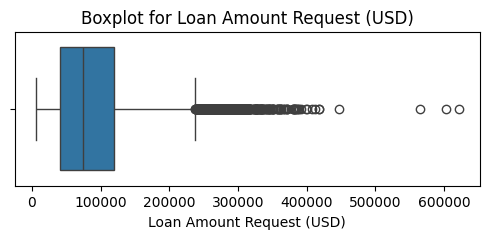

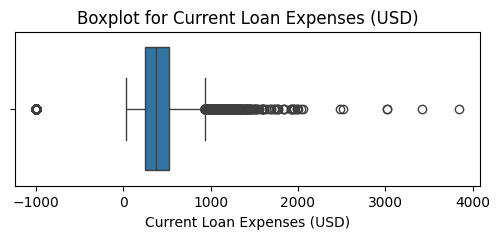

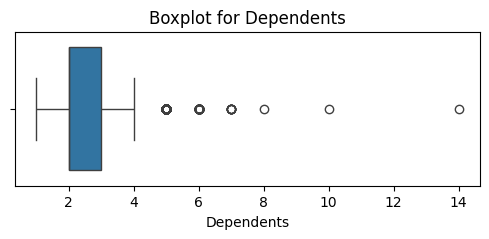

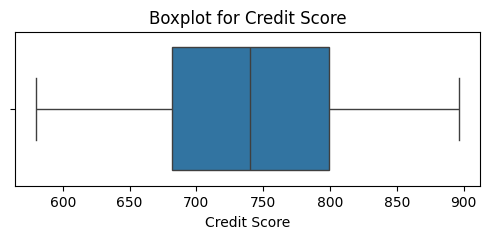

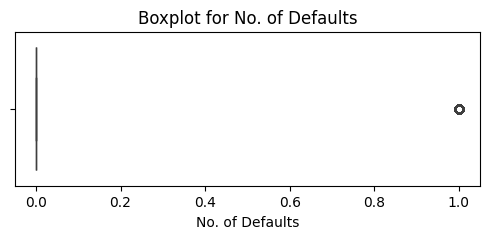

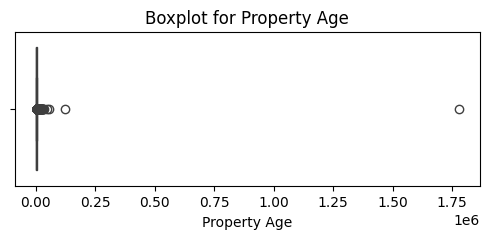

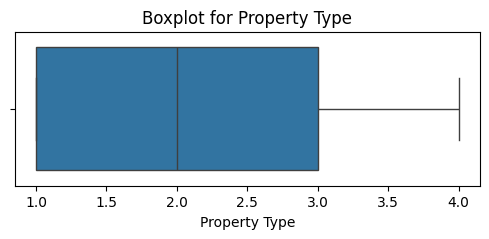

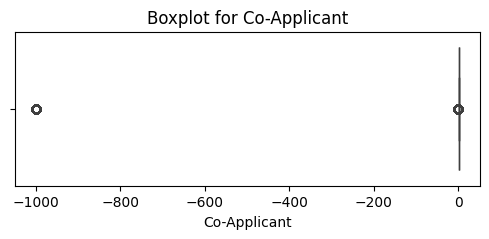

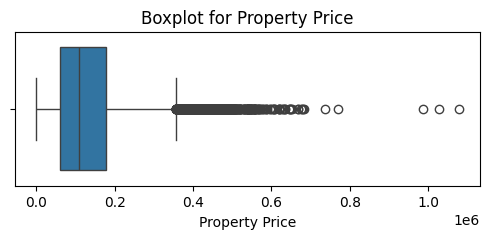

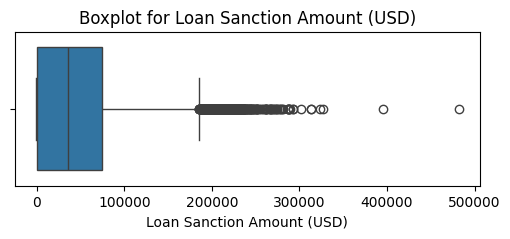

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from joblib import parallel_backend
import warnings
warnings.filterwarnings('ignore')

''' Load data '''
df = pd.read_csv("C:\\Users\\Kavi\\Downloads\\train.csv\\train.csv")
df.head()

#Descriptive statistics and info
display(df.info())
display(df.describe())

# Counting null values across each features
df.isnull().sum()

# Drop unrequired columns
df.drop(['Customer ID', 'Name', 'Property ID'], axis=1, inplace=True)

# Visualize numeric feature distributions
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[numeric_cols].hist(figsize=(15, 10), bins=30)
plt.suptitle("Initial Distribution of Numerical Features (Raw Data)")
plt.show()

# Correlation Heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

''' Boxplots for outlier detection '''
num_cols = df.select_dtypes(include=['int64','float64']).columns
for col in num_cols:
    plt.figure(figsize=(6, 2))
    sns.boxplot(data=df, x=col)
    plt.title(f"Boxplot for {col}")
    plt.show()

# Outlier removal using IQR method
Q1 = df[num_cols].quantile(0.25)
Q3 = df[num_cols].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df[num_cols] < (Q1 - 1.5 * IQR)) | (df[num_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]


''' Recompute column types after dropping '''
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = df.select_dtypes(include='object').columns.tolist()
ordinal_cols = ['Income Stability', 'Location', 'Has Active Credit Card',
                'Expense Type 1', 'Expense Type 2']
cat_cols = [col for col in cat_cols if col not in ordinal_cols]

# Remove target from numerical columns
num_cols.remove('Loan Sanction Amount (USD)')

df = df[df['Loan Sanction Amount (USD)'] > 0].reset_index(drop=True)

# Define X and y
X = df.drop('Loan Sanction Amount (USD)', axis=1)
y = df['Loan Sanction Amount (USD)']

# Define transformers
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])


ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder())
])

# Update categorical transformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('ord', ordinal_transformer, ordinal_cols),
    ('cat', categorical_transformer, list(set(cat_cols) - set(ordinal_cols)))
])

In [2]:
# Plot learning curve
def plot_learning_curve(estimator, X, y, title="Learning Curve", cv=5, scoring="r2"):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5), shuffle=True, random_state=42)

    train_scores_mean = np.mean(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)

    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score")
    plt.plot(train_sizes, val_scores_mean, 'o-', label="Cross-validation score")
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel(scoring)
    plt.legend(loc="best")
    plt.grid()
    plt.show()

'''
# Example usage with Linear Regression
model = Pipeline(steps=[("preprocessor", preprocessor),
                        ("regressor", LinearRegression())])
with parallel_backend('threading', n_jobs=-1):
    plot_learning_curve(model, X, y)
    '''

'\n# Example usage with Linear Regression\nmodel = Pipeline(steps=[("preprocessor", preprocessor),\n                        ("regressor", LinearRegression())])\nwith parallel_backend(\'threading\', n_jobs=-1):\n    plot_learning_curve(model, X, y)\n    '

In [3]:
def performance_plots(y_test, y_test_pred):
    # Residual Plot
    residuals = y_test - y_test_pred
    plt.figure(figsize=(6,4))
    sns.histplot(residuals, kde=True)
    plt.title("Residual Distribution")
    plt.xlabel("Residuals")
    plt.show()

    # Predicted vs Actual
    plt.figure(figsize=(6,6))
    sns.scatterplot(x=y_test, y=y_test_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.title("Predicted vs Actual")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.grid()
    plt.show()


In [4]:
def validate_metrics(y_val,y_val_pred):
    # Validation metrics
    val_mse = mean_squared_error(y_val, y_val_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    val_rmse = np.sqrt(val_mse)
    val_r2 = r2_score(y_val, y_val_pred)

    print("----- Validation Metrics -----")
    print(f"Validation MAE: {val_mae:.2f}")
    print(f"Validation MSE: {val_mse:.2f}")
    print(f"Validation RMSE: {val_rmse:.2f}")
    print(f"Validation R²: {val_r2:.4f}")

In [5]:
def test_metrics(y_test,y_test_pred):
    # Test metrics
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(y_test, y_test_pred)

    print("\n----- Test Metrics -----")
    print(f"Test MAE: {test_mae:.2f}")
    print(f"Test MSE: {test_mse:.2f}")
    print(f"Test RMSE: {test_rmse:.2f}")
    print(f"Test R²: {test_r2:.4f}")

In [6]:
def kfold(pipeline):
    ''' K-Fold CV '''
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    mae_scores = []
    mse_scores = []
    rmse_scores = []
    for train_idx, val_idx in kfold.split(X):
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
        
        pipeline.fit(X_train_fold, y_train_fold)
        y_pred = pipeline.predict(X_val_fold)
        
        mae = mean_absolute_error(y_val_fold,y_pred)
        mse = mean_squared_error(y_val_fold,y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_val_fold, y_pred)
        print(f'MAE : {mae:.2f} , MSE : {mse:.2f} , RMSE : {rmse:.2f} , R2 : {r2:.2f}')
        scores.append(r2)
        mae_scores.append(mae)
        mse_scores.append(mse)
        rmse_scores.append(rmse)

    print(f"Average R² across 5 folds: {np.mean(scores):.4f}")
    print(f"Average MAE across 5 folds: {np.mean(mae_scores):.4f}")
    print(f"Average MSE across 5 folds: {np.mean(mse_scores):.4f}")
    print(f"Average RMSE across 5 folds: {np.mean(rmse_scores):.4f}")

In [7]:
def fit_model(X_train, y_train, X_val, y_val, X_test, y_test,pipeline):
    pipeline.fit(X_train, y_train)              # Fit the pipeline on training data
    y_val_pred = pipeline.predict(X_val)        # Predict on validation data
    validate_metrics(y_val, y_val_pred)         # Validation metrics

    y_test_pred = pipeline.predict(X_test)      # Predict on test data
    test_metrics(y_test, y_test_pred)           # Test metrics
    performance_plots(y_test, y_test_pred)

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

# Linear Regression Pipeline
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# SVR Pipeline
svr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', SVR())
])

# AdaBoost Pipeline
adaboost_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', AdaBoostRegressor())
])

# Gradient Boosting Pipeline
gboost_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor())
])

# XGBoost Pipeline
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(objective="reg:squarederror"))
])

In [9]:
# Step 3: Split data into train, validation, and test sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

----- Validation Metrics -----
Validation MAE: 3148.68
Validation MSE: 18439475.88
Validation RMSE: 4294.12
Validation R²: 0.9862

----- Test Metrics -----
Test MAE: 3126.74
Test MSE: 18565888.59
Test RMSE: 4308.82
Test R²: 0.9855


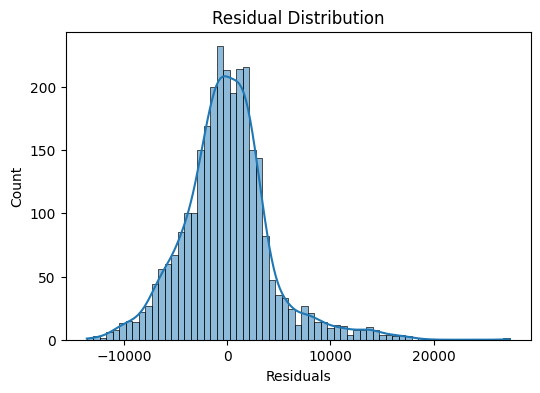

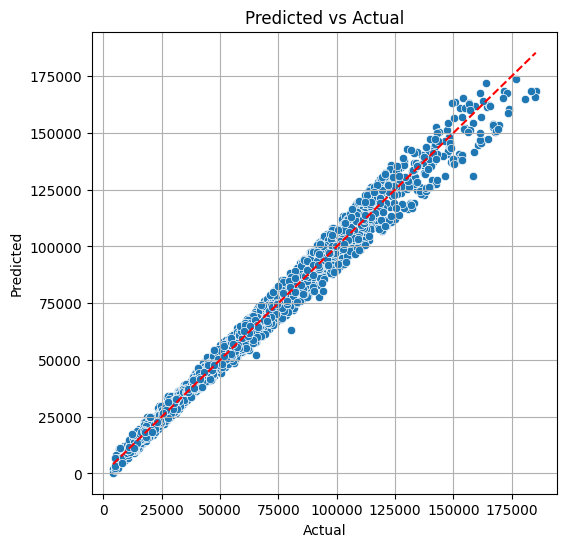


----- K-Fold Cross-Validation for Linear Regression -----
MAE : 3129.42 , MSE : 18551597.73 , RMSE : 4307.16 , R2 : 0.99
MAE : 3079.05 , MSE : 18188836.99 , RMSE : 4264.84 , R2 : 0.99
MAE : 3115.78 , MSE : 18223159.98 , RMSE : 4268.86 , R2 : 0.99
MAE : 3152.64 , MSE : 18691139.54 , RMSE : 4323.33 , R2 : 0.99
MAE : 3173.19 , MSE : 19185272.34 , RMSE : 4380.10 , R2 : 0.99
Average R² across 5 folds: 0.9858
Average MAE across 5 folds: 3130.0141
Average MSE across 5 folds: 18568001.3171
Average RMSE across 5 folds: 4308.8556


In [10]:
# Linear Regression Model
fit_model(X_train, y_train, X_val, y_val, X_test, y_test, lr_pipeline)

# K-Fold Cross-Validation
print("\n----- K-Fold Cross-Validation for Linear Regression -----")
kfold(lr_pipeline)

----- Validation Metrics -----
Validation MAE: 4523.85
Validation MSE: 32371230.28
Validation RMSE: 5689.57
Validation R²: 0.9758

----- Test Metrics -----
Test MAE: 4548.12
Test MSE: 32795807.08
Test RMSE: 5726.76
Test R²: 0.9744


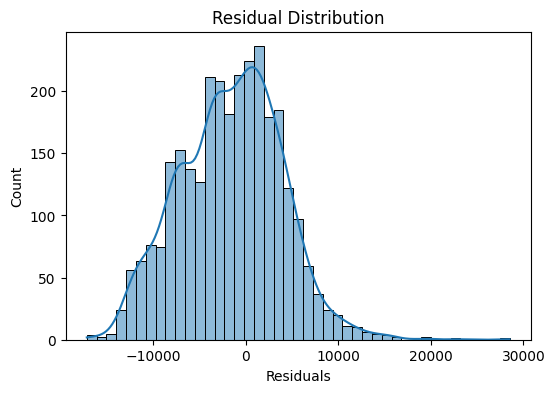

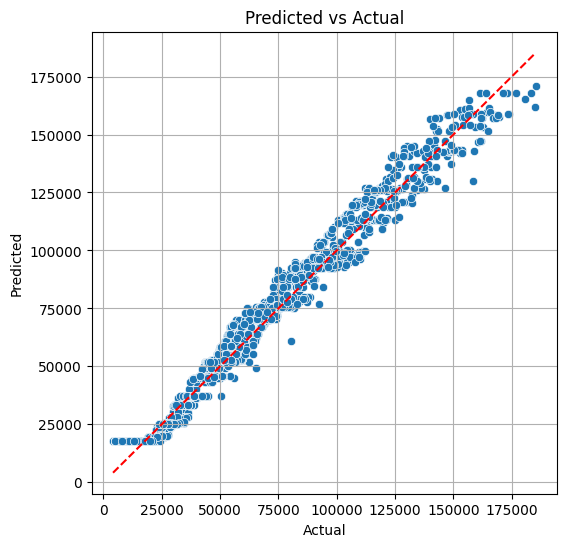


----- K-Fold Cross-Validation for Adaboost Regressor -----
MAE : 4761.05 , MSE : 35016899.53 , RMSE : 5917.51 , R2 : 0.97
MAE : 4595.12 , MSE : 33548659.96 , RMSE : 5792.12 , R2 : 0.97
MAE : 4813.18 , MSE : 35914091.35 , RMSE : 5992.84 , R2 : 0.97
MAE : 4924.76 , MSE : 36930278.18 , RMSE : 6077.03 , R2 : 0.97
MAE : 4981.21 , MSE : 37636234.74 , RMSE : 6134.84 , R2 : 0.97
Average R² across 5 folds: 0.9726
Average MAE across 5 folds: 4815.0641
Average MSE across 5 folds: 35809232.7514
Average RMSE across 5 folds: 5982.8663


In [11]:
# Adaboost Regressor Model
fit_model(X_train, y_train, X_val, y_val, X_test, y_test, adaboost_pipeline)

# K-Fold Cross-Validation
print("\n----- K-Fold Cross-Validation for Adaboost Regressor -----")
kfold(adaboost_pipeline)

----- Validation Metrics -----
Validation MAE: 2656.24
Validation MSE: 13543073.58
Validation RMSE: 3680.09
Validation R²: 0.9899

----- Test Metrics -----
Test MAE: 2641.28
Test MSE: 13396303.72
Test RMSE: 3660.10
Test R²: 0.9896


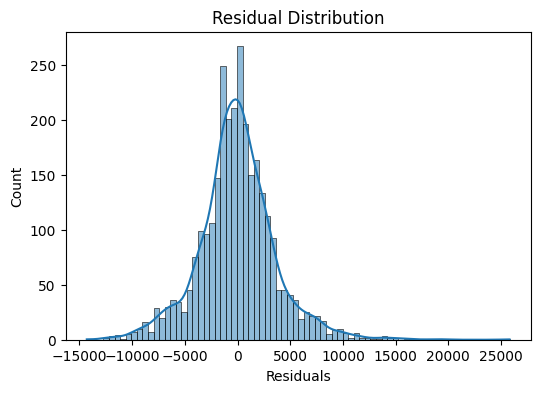

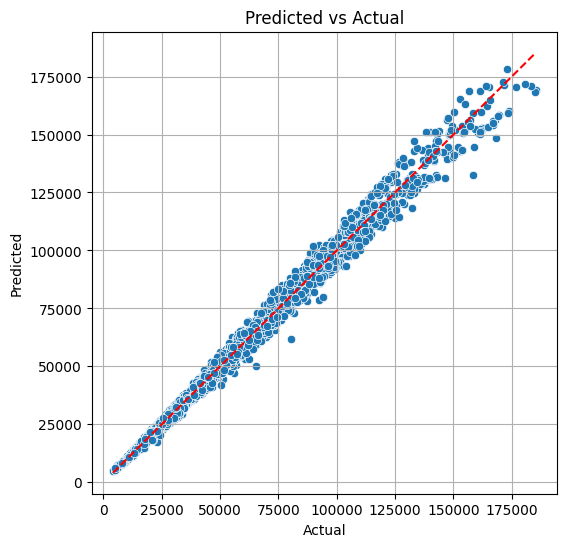


----- K-Fold Cross-Validation for Gradient Boosting Regressor -----
MAE : 2624.41 , MSE : 13193135.81 , RMSE : 3632.24 , R2 : 0.99
MAE : 2601.68 , MSE : 13451423.76 , RMSE : 3667.62 , R2 : 0.99
MAE : 2626.95 , MSE : 12999735.05 , RMSE : 3605.51 , R2 : 0.99
MAE : 2648.53 , MSE : 13495109.89 , RMSE : 3673.57 , R2 : 0.99
MAE : 2718.31 , MSE : 14508480.14 , RMSE : 3809.00 , R2 : 0.99
Average R² across 5 folds: 0.9897
Average MAE across 5 folds: 2643.9764
Average MSE across 5 folds: 13529576.9317
Average RMSE across 5 folds: 3677.5875


In [12]:
# Gradient Boosting Regressor Model
fit_model(X_train, y_train, X_val, y_val, X_test, y_test, gboost_pipeline)

# K-Fold Cross-Validation
print("\n----- K-Fold Cross-Validation for Gradient Boosting Regressor -----")
kfold(gboost_pipeline)

----- Validation Metrics -----
Validation MAE: 28824.10
Validation MSE: 1366066384.40
Validation RMSE: 36960.34
Validation R²: -0.0214

----- Test Metrics -----
Test MAE: 28012.84
Test MSE: 1309517437.31
Test RMSE: 36187.26
Test R²: -0.0202


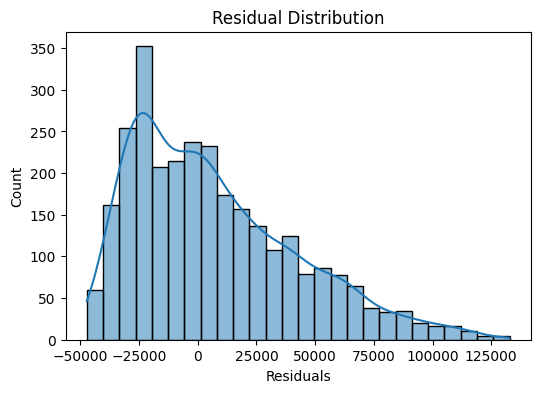

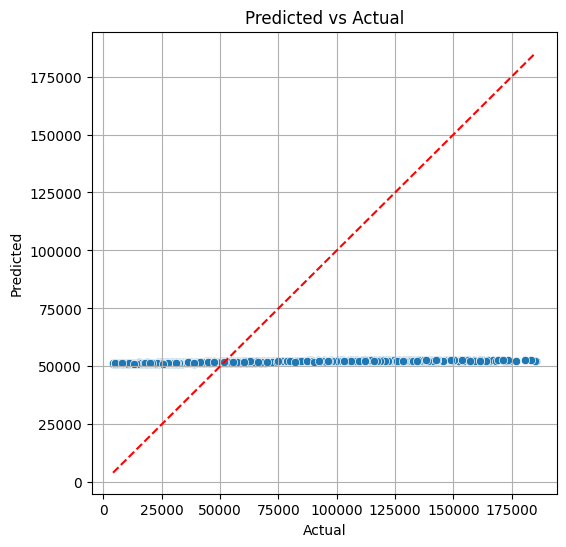


----- K-Fold Cross-Validation for Support Vector Regressor -----
MAE : 27898.66 , MSE : 1299201165.51 , RMSE : 36044.43 , R2 : -0.01
MAE : 28511.35 , MSE : 1336612802.56 , RMSE : 36559.72 , R2 : -0.02
MAE : 28221.68 , MSE : 1277063068.06 , RMSE : 35736.02 , R2 : -0.01
MAE : 29228.01 , MSE : 1401585320.17 , RMSE : 37437.75 , R2 : -0.02
MAE : 28474.22 , MSE : 1305763146.40 , RMSE : 36135.34 , R2 : -0.00
Average R² across 5 folds: -0.0114
Average MAE across 5 folds: 28466.7820
Average MSE across 5 folds: 1324045100.5395
Average RMSE across 5 folds: 36382.6531


In [13]:
# Support Vector Regressor Model
fit_model(X_train, y_train, X_val, y_val, X_test, y_test, svr_pipeline)

# K-Fold Cross-Validation
print("\n----- K-Fold Cross-Validation for Support Vector Regressor -----")
kfold(svr_pipeline)

----- Validation Metrics -----
Validation MAE: 2801.77
Validation MSE: 16043427.58
Validation RMSE: 4005.42
Validation R²: 0.9880

----- Test Metrics -----
Test MAE: 2807.66
Test MSE: 16114177.94
Test RMSE: 4014.25
Test R²: 0.9874


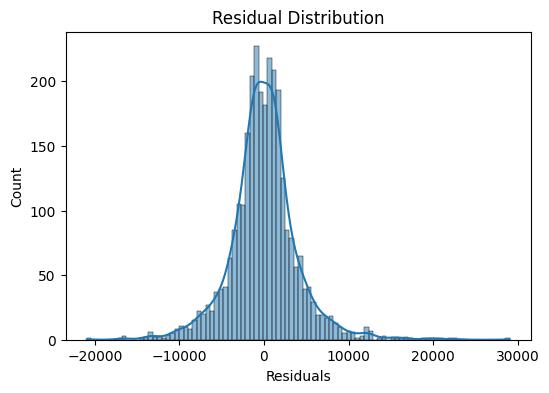

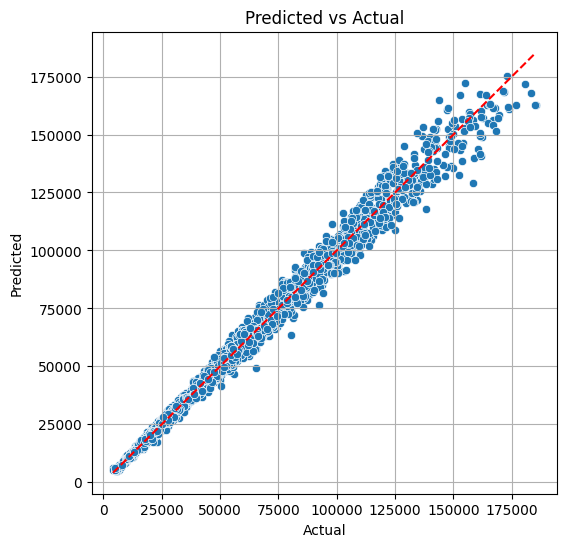


----- K-Fold Cross-Validation for XGBoost Regressor -----
MAE : 2747.57 , MSE : 15272784.94 , RMSE : 3908.04 , R2 : 0.99
MAE : 2766.60 , MSE : 15872905.26 , RMSE : 3984.08 , R2 : 0.99
MAE : 2762.78 , MSE : 15374335.72 , RMSE : 3921.01 , R2 : 0.99
MAE : 2847.29 , MSE : 16875161.62 , RMSE : 4107.94 , R2 : 0.99
MAE : 2827.98 , MSE : 16556578.57 , RMSE : 4068.98 , R2 : 0.99
Average R² across 5 folds: 0.9878
Average MAE across 5 folds: 2790.4428
Average MSE across 5 folds: 15990353.2229
Average RMSE across 5 folds: 3998.0102


In [14]:
# Support Vector Regressor Model
fit_model(X_train, y_train, X_val, y_val, X_test, y_test, xgb_pipeline)

# K-Fold Cross-Validation
print("\n----- K-Fold Cross-Validation for XGBoost Regressor -----")
kfold(xgb_pipeline)